##### Imports section

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
import random
from datetime import datetime
import time
import json

from langchain.schema.runnable import RunnableSequence

In [2]:
# Do imports for deh experiments specific modules
from pathlib import Path

utils_folder = Path("..")
sys.path.append(str(utils_folder))
utils_folder = Path("../src/deh")
sys.path.append(str(utils_folder))
utils_folder = Path(".")
sys.path.append(str(utils_folder))

import deh_globals
globals().update(deh_globals.__dict__)
import squad_scoring
globals().update(deh_globals.__dict__)
import deh_prompts
import deh_vector_store
globals().update(deh_vector_store.__dict__)
import deh_squad_data
import deh_hyde
import deh_experiments_config
globals().update(deh_experiments_config.__dict__)
import deh_llm
globals().update(deh_llm.__dict__)

### I.) Define the current Experiment

Currently, the notebook runs one single  experiment that is selected in the next cell. However, it can easily be adapted to run more than one experiment. All experiments are defined and configured in the module "deh_experiments_config.py". Furthermore, in the next cell a series of global parameters are set. These depend on the choice of the experiment

In [3]:
current_experiment = experiments["FINAL_FINAL_RAG_TR_90"]

#EXPERIMENT_GLOBAL_ID = current_experiment["name"]
DEFAULT_CHUNKING_METHOD = current_experiment["chunking_method"]
CHAT_MODEL_NAME = current_experiment["llm_model"]
TEMPERATURE = current_experiment["temperature"]
VECTOR_STORE_TOP_K = current_experiment["vector_store_top_k"]
JUDGES_SUPPRESS_THRESHOLD = current_experiment["judges_suppress_threshold"]

### II.) Functions for loading and initializing Data

Next, the SQuAD dataset set (Version v2.0, dev set) is loaded in raw format from a csv file into a dataset. Loading the dataset in its raw format is useful for some of the functions of the notebook. After reading in the raw dataset, several dataframes are created to show statistics about the dataframe.

Please note the following two important points:

- throughout this notebook the term "title" and "article" are used as synonyms
- the SQuAD dataset contains text passages from Wikipedia articles. Each such segment is called "context" and belongs to one of the articles. This is a source of confusion since the items retrieved from a vector store as the result of a similarity search are also called "contexts". Wherever possible, we will try to distinguish these two different meanings of the word "context" (so ulimtately, the meaning of the word "context", depends on the context it is used in :-) ).

In [4]:
print(f"Loading squad data...")

column_names = ["title", "squad_context", "qid", "question", "is_impossible", "answer"]

try:
    squad_raw = pd.read_csv(f"{DATA_ROOT}/squad_raw.csv", names=column_names, skiprows=1)
    print(f"Loaded squad data from {DATA_ROOT}/squad_raw.csv\n")
except:
    print(f"Failed to load squad data from {DATA_ROOT}/squad_raw.csv")

df_squad_raw = pd.DataFrame(squad_raw)
print(f"Number of raw entries in squad_raw:   {len(df_squad_raw)}")

df_titles = pd.DataFrame(df_squad_raw['title'].unique(), columns=["title"])
print(f"Number of unique titles:                 {len(df_titles)}")

df_contexts = pd.DataFrame(df_squad_raw['squad_context'].unique(), columns=["squad_context"])
print(f"Number of unique contexts:             {len(df_contexts)}")

df_qas = df_squad_raw[['title', 'squad_context', 'qid', 'question', 'is_impossible']].drop_duplicates()
df_qas = df_qas.reset_index(drop=True)
print(f"Number of unique questions:           {len(df_qas)}")

df_squad_answers = df_squad_raw[['qid', 'question', 'answer']].drop_duplicates()
print(f"Number of unique answers:             {len(df_squad_answers)}")           
            

Loading squad data...
Loaded squad data from ../../../deh_data_results/data/squad_raw.csv

Number of raw entries in squad_raw:   26232
Number of unique titles:                 35
Number of unique contexts:             1204
Number of unique questions:           11858
Number of unique answers:             16209


##### Intialize the Vector Store (Chroma; Milvus is analysed separately); if configured, re-chunk the data

Next, the vector store is initialized. If the global variable CHUNK_SQUAD_DATASET is set to True, the dataset is chunked by calling the method chunk_squad_dataset(). Chunking depends on the current chunking method, the chunk size and the chunk overlap.If no chunking is done, the vector store has to already exist.

In [5]:
contexts = list(df_contexts["squad_context"].values)

if CHUNK_SQUAD_DATASET:    
    deh_vector_store.chunk_squad_dataset(contexts, dataset, CHUNK_SIZE, CHUNK_OVERLAP)
else:
    print("Chunking not foreseen. Skipping chunking.")

# Intiialize the Chroma vector store
vector_store = deh_vector_store.get_vector_store(DEFAULT_CHROMA_PREFIX, DEFAULT_CHUNKING_METHOD)

Chunking not foreseen. Skipping chunking.
Will now get the following vector store: ../../../deh_data_results/chroma/chroma/chroma_deh_rag_db_k5_cs1000_per_article


##### Loading qas with contexts data (if data is not to be restored)

All experiments are carried out using a dataframe called "df_qas_with_contexts". This file contains the following columns:
title	squad_context	qid	question	is_impossible	hyde_article	question_context	hyde_based_context

- title: the title of the corrsponding Wikipedia article (e.g. Normans, Computational_complexity_theory, etc.)
- squad_context: the text passage from the Wikipedia article to which the question relates
- qid: the id of the question
- question: the question itself
- is_impossible: False, if the question can be answered from the squad_context, True if not (i.e. the article does not contain the necessary information to answer the question)
- hyde_article: if not empty, the corresponding Hyde article that has been generated by an LLM for the question
- question_context: the contexts retrieved from the vector store based on the question (depends on k, the chunking method and the chunking size)
- hyde_based_context: the contexts retrieved from the vector store based on the Hyde article (depends on k, the chunking method and the chunking size)

An important aspect to keep in mind here is that, for reasons of efficiency, all contexts are pre-created and stored in corresponding csv files. This accelartates running experiments, since if several experiments need to be run in succession or an experiment needs to be repeatedly run with different paramteres, then contexts do not need to be retrieved on the fly again and again for each experiment. It is important to note that these contexts depend on the number k of contexts that the vector store must  return and also on the chunking strategy that is being used, the chunking size and the chunking overlap. Furthermore, it is important to note that retrieving chunks from a vector store is a deterministic process (at least in our experiments settings) and that therefore, chunks can be created ahead of running the experiments.

Another important point to note is that not all contexts based on Hyde have been created. The reason for that is that creating Hyde articles is very time consuming and therefore, the number of available Hyde articles is currently limited to approx. 4000. 

In [6]:
# This method gets the qas_with_contexts data from a csv file. Depending on the chunking 
# method (naive, per_context, per_article, pseudo_semantic), the chunk size and the paramter k,
# it gets the data from a different csv file. The csv file contains all the necessary context 
# data and must already exist. If it does not, or if contexts need to be created for the 
# current experiment configuration, then this can be done by setting the global parameter
# RESTORE_QAS_WITH_CONTEXTS and/or REFRESH_QUESION_CONTEXTS and REFRESH_HYDE_CONTEXTS.
# Normally, creating contexts should not be a frequently used operation and once created,
# reading qas_with_contexts data from a csv file should be the normal mode of operation.
def load_qas_with_contexts_from_file(chunking_method):
    
    file_path = f"{DATA_ROOT}/qas_with_contexts_k{VECTOR_STORE_TOP_K}_cs{CHUNK_SIZE}_{chunking_method}.csv"
    print(f"Loading qas_with_contexts from the CSV file: {file_path}\n...")
    
    try:
        df_qas_with_contexts = pd.read_csv(file_path) #, names=column_names)
        print(f"Loaded qas_with_contexts from {file_path}\n...")
    except Exception as e:  # Catch all exceptions
        print(f"An error has occurred: {e}")
        print(f"Failed to load qas_with_contexts from {file_path}")
        sys.exit(1)

    # TODO: the followin if statement can probably be removed. Check if 
    # is still needed and if not, remove it.
    # drop the answer column if it exists, since it leads to duplicates
    if 'answer' in df_qas_with_contexts.columns:
        df_qas_with_contexts = df_qas_with_contexts.drop(columns=['answer'])

    df_qas_with_contexts = df_qas_with_contexts.drop_duplicates()

    print(f"Rows in dataframe df_qas_with_contexts: {len(df_qas_with_contexts)}")
    
    hyde_articles_cnt = df_qas_with_contexts['hyde_article'].notna().sum()
    hyde_based_contexts_cnt = df_qas_with_contexts['hyde_based_context'].notna().sum()
    print(f"Number of questions with Hyde articles: {hyde_articles_cnt}")
    print(f"Number of questions with Hyde based contexts: {hyde_based_contexts_cnt}")

    return df_qas_with_contexts

In [7]:
# If not restoring qas_with_contexts from the CSV file, then read
# the data from the csv file (i.e. it exists and is correct).
# Else, the contexts will be (re-) created in one of the cells below
# in the notebook.
if not RESTORE_QAS_WITH_CONTEXTS:
    df_qas_with_contexts = load_qas_with_contexts_from_file(DEFAULT_CHUNKING_METHOD)
    df_qas_with_contexts_semantic = load_qas_with_contexts_from_file(DEFAULT_SEMANTIC_CHUNKING_METHOD)
else:
    print(f"RESTORE_QAS_WITH_CONTEXTS is True. Skipping loading qas_with_contexts from the CSV file.")

Loading qas_with_contexts from the CSV file: ../../../deh_data_results/data/qas_with_contexts_k5_cs1000_per_article.csv
...
Loaded qas_with_contexts from ../../../deh_data_results/data/qas_with_contexts_k5_cs1000_per_article.csv
...
Rows in dataframe df_qas_with_contexts: 11858
Number of questions with Hyde articles: 3918
Number of questions with Hyde based contexts: 3918
Loading qas_with_contexts from the CSV file: ../../../deh_data_results/data/qas_with_contexts_k5_cs1000_naive.csv
...
Loaded qas_with_contexts from ../../../deh_data_results/data/qas_with_contexts_k5_cs1000_naive.csv
...
Rows in dataframe df_qas_with_contexts: 11858
Number of questions with Hyde articles: 3918
Number of questions with Hyde based contexts: 3918


##### Restore qas with contexts (if configured); alternatively refreseh contexts in existing file

In [8]:
# Only used for restoring the qas_with_contexts data, should it be missing or corrupted
# Normally, this should not be frequently needed. When the function is called,
# df_qas contains the initial raw data, as it has been read from the SQuAD raw file.
#
# Please also note: Hyde data (articles and contexts) is stored in a separate file (Hyde articles
# are generated in a separate module).

def restore_df_qas_with_contexts_file(file_path, df_qas):

    # Add columns hyde_article, question_context, hyde_based_context to df_qas_with_contexts
    # since the raw data does not contain these columns
    if not 'hyde_article' in df_qas.columns:
        df_qas['hyde_article'] = np.nan
    if not 'question_context' in df_qas.columns:
        df_qas['question_context'] = np.nan
    if not 'hyde_based_context' in df_qas.columns:
        df_qas['hyde_based_context'] = np.nan

    # Get Hyde data
    hyde_based_context_path = f"{HYDE_BASED_CONTEXTS_ROOT}/hyde_based_contexts.csv"
    df_hyde_based_contexts = pd.read_csv(hyde_based_context_path)

    print(f"Rows in dataframe df_hyde_based_contexts: {len(df_hyde_based_contexts)}")
    hyde_articles_cnt = df_hyde_based_contexts['hyde_article'].notna().sum()
    hyde_based_contexts_cnt = df_hyde_based_contexts['hyde_based_context'].notna().sum()

    # Merge df_qas with df_hyde_based_contexts based on the 'qid' column
    merged = df_qas.merge(df_hyde_based_contexts, on='qid', how='left', suffixes=('', '_df_hyde_based_contexts'))
    df_qas['hyde_article'] = merged['hyde_article_df_hyde_based_contexts']

    print(f"Number of questions with Hyde articles: {hyde_articles_cnt}")
    print(f"Number of questions with Hyde based contexts: {hyde_based_contexts_cnt}")

    df_qas.to_csv(file_path, header=True, index=False)


In [9]:
# TODO --> add check if qas_with_contexts file already exists

# The following is only needed if the qas_with_contexts file is missing or
# corrupted or if the contexts need to be refreshed for any reason.

if RESTORE_QAS_WITH_CONTEXTS:
    restore_file_path = f"{DATA_ROOT}/qas_with_contexts_k{VECTOR_STORE_TOP_K}_cs{CHUNK_SIZE}_{DEFAULT_CHUNKING_METHOD}.csv"
    restore_df_qas_with_contexts_file(restore_file_path, df_qas)

# Refresh normal question contexts and hyde-based contexts
# TODO: check if might be useful to first empty the two contexts columns in the dataframe
if RESTORE_QAS_WITH_CONTEXTS or REFRESH_QUESTION_CONTEXTS or REFRESH_HYDE_CONTEXTS:
    print(f"Re-Generating contexts for the dataset and persisting the data...")
    list_of_qas = df_qas.to_dict(orient='records')

    for i, qa in enumerate(list_of_qas):
        # print(i)
        if i %100 == 0:
            print(f"Processing question {i}...")

        # Generating contexts based on questions (if necessary)
        if RESTORE_QAS_WITH_CONTEXTS or REFRESH_QUESTION_CONTEXTS:
            question = qa["question"]
            
            top_docs = vector_store.similarity_search(
                query = question,
                k = VECTOR_STORE_TOP_K,
            )
            qa["question_context"] = "\n\n".join([top_doc.page_content for top_doc in top_docs])

        # Generating contexts based on Hyde articles (if necessary)
        if RESTORE_QAS_WITH_CONTEXTS or REFRESH_HYDE_CONTEXTS:
            hyde_article = qa["hyde_article"]
            #print(f"hyde_article: {hyde_article}")
            if pd.isna(hyde_article):
                hyde_article = ""
            elif len(hyde_article) == 0:
                hyde_article = ""
            else:
                top_docs = vector_store.similarity_search(
                    query = hyde_article,
                    k = VECTOR_STORE_TOP_K,
                )

                qa["hyde_based_context"] = "\n\n".join([top_doc.page_content for top_doc in top_docs])

    df_qas = pd.DataFrame(list_of_qas)
    df_qas_with_contexts = df_qas.copy()
    df_qas.to_csv(restore_file_path, header=True, index=False)
else:
    print(f"Not restoring df_qas_with_contexts or refresh of the contexts...")

Not restoring df_qas_with_contexts or refresh of the contexts...


##### Show names of all dataframes

Just for a general overview, generate all the dataframes that have been created up to now.

In [10]:
import copy 

print("Names of Dataframes and their lenghts:\n")
global_keys_copy = copy.deepcopy(list(globals().keys()))

my_l = [{n: len(globals()[n])} for n in global_keys_copy if n.startswith("df_")]
df_dfs = pd.DataFrame([(k, v) for d in my_l for k, v in d.items()], columns=['df name', 'rows'])
df_dfs


Names of Dataframes and their lenghts:



,df name,rows
0,df_experiments,45
1,df_squad_raw,26232
2,df_titles,35
3,df_contexts,1204
4,df_qas,11858
5,df_squad_answers,16209
6,df_qas_with_contexts,11858
7,df_qas_with_contexts_semantic,11858


### III.) Functions for persisting Results (including histograms)

This section contains functions that are needed for storing the output (results) of an experiment. In particular, the following files are created as an output of the experiment in a folder created by the function "create_results_folder" that depends on the current time stamp, the global variable RESULTS_ROOT and the name of the current experiment:

- experiments_config_<experiment_name>.txt: information about the experiment configuration used for running the experiment
- <experiment_name>_<bootstrap_cnt>_<sample_size>.png: histogram of F1 distribution resulting from bootstrapping
- eval_dict_<experiment_name>.json: scoring for the predictions created during the experiment run (bootstrapping not involved in this case!)
- qas_<experiment_name>_answers.csv: question and corresponding LLM-generated answers obtained during the experiment run
- qas_<experiment_name>_answers.json: same as above, but in json format
- qas_<experiment_name>_scores.csv: contains all the data from qas_with_contexts file, plus all the scores for each one of the question/answer pairs
- df_ragas_input.csv: draft input file for ragas. Contains question, LLM-generated answer, context used as well as the ground_truth

In [11]:
# Get the current timestamp and format the start timestamp as a string
def get_timestamp_as_string():
    start_timestamp = datetime.now()
    start_timestamp_str = start_timestamp.strftime('%Y%m%d_%H%M%S')
    return start_timestamp_str

In [12]:
# Create the folder that will be used for storing all experiments results
def create_results_folder(start_timestamp_str, experiment_name=None):

    if experiment_name:
        results_folder_name = f"{RESULTS_ROOT}/{experiment_name}_{start_timestamp_str}/{experiment_name}"
    else:
        results_folder_name = f"{RESULTS_ROOT}/{experiment_name}_{start_timestamp_str}"
    if not os.path.exists(results_folder_name):
        os.makedirs(results_folder_name, exist_ok=True)
    return results_folder_name

In [13]:
# Creates the following files in the results folder:
#
# - qas_<experiment_name>_scores.csv: contains all the data from qas_with_contexts file, plus all the scores for each one of the question/answer pairs
# - qas_<experiment_name>_answers.csv: question and corresponding LLM-generated answers obtained during the experiment run
# - eval_dict_<experiment_name>.json: scoring for the predictions created during the experiment run (bootstrapping not involved in this case!)
 
def persist_results(results_folder_name, experiment_name, df, eval_dict):

    df.to_csv(f"{results_folder_name}/qas_{experiment_name.lower()}_scores.csv", header=True, index=False)
    df[['qid', 'question', f"{experiment_name.lower()}_llm_answer"]].to_csv(f"{results_folder_name}/qas_{experiment_name.lower()}_answers.csv", header=True, index=False)
   
    json_file_name = f"{results_folder_name}/qas_{experiment_name.lower()}_answers.json"
    df_json = df[['qid', f"{experiment_name.lower()}_llm_answer"]].rename(columns={f"{experiment_name.lower()}_llm_answer": "answer"})
    answer_data = {row["qid"]: row["answer"] for _, row in df_json.iterrows()}
    with open(json_file_name, "w") as json_file:
        json.dump(answer_data, json_file, indent=4)

    eval_dict_file_name = f"{results_folder_name}/eval_dict_{experiment_name.lower()}.json"
    eval_data = {key: round(value, 2) for key, value in eval_dict.items()}
    with open(eval_dict_file_name, "w") as json_file:
        json.dump(eval_data, json_file, indent=4)

In [14]:
# Generates a histogram for the list of scores in scores_l and persist it in the directory "results_folder_name"
def generate_histogram(scores_l, mean, ci, results_folder_name, experiment_name):

    plt.clf
    plt.hist(scores_l, bins=30, density=False, edgecolor='black', alpha=0.6, color = 'lightblue' ) # color='aquamarine')
    plt.xlim(0, 100)

    plt.title(f"F1-Scores for {experiment_name} - (Bootstraps: {BOOTSTRAPS_N:,} - Sample Size: {SAMPLE_SIZE:,})", fontsize=10)
    plt.xlabel("F1-Score")
    plt.ylabel("Frequency")

    # Add a vertical line for the mean
    max_len = 6
    mean_label = f"{mean: .2f}".rjust(max_len)
    plt.axvline(mean, color='red', linestyle='dotted', linewidth=2, label=f'Mean F1:          {mean_label}')

    # Add vertical lines for the 95% confidence interval
    lower = f"{ci[0]: .2f}".rjust(max_len)
    upper = f"{ci[1]: .2f}".rjust(max_len)
    plt.axvline(ci[0], color='orange', linestyle='dashdot', linewidth=1.5, label=f"95% CI Lower:  {lower}")
    plt.axvline(ci[1], color='orange', linestyle='dashdot', linewidth=1.5, label=f"95% CI Upper:  {upper}")

    ax = plt.gca()  # Get current axis
    ax.xaxis.set_major_locator(MultipleLocator(10))  # Set major ticks every 10 units
    ax.xaxis.set_minor_locator(MultipleLocator(5))   # Set minor ticks every 5 units
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
    
    # Customize grid for major and minor ticks
    ax.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', color='lightgray', linestyle=':', linewidth=0.5)

    # Add a legend

    # Add additional text to the legend
    from matplotlib.lines import Line2D

    handles, labels = ax.get_legend_handles_labels()
    model_info_line = Line2D([0], [0], color='none', label=f"LLM Model: {CHAT_MODEL_NAME}")
    labels.append(f"LLM Model: {CHAT_MODEL_NAME}")
    handles.append(model_info_line)

    if experiment_name == "BASIC_RAG_SEMANTIC_CHUNKGING":
        labels.append(f"K={VECTOR_STORE_TOP_K} / {DEFAULT_SEMANTIC_CHUNKING_METHOD}")
    else:
        labels.append(f"K={VECTOR_STORE_TOP_K} / {DEFAULT_CHUNKING_METHOD}")
    handles.append(model_info_line)

    plt.legend(prop={'family': 'monospace', 'size': 9})
    plt.legend(handles, labels, loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(results_folder_name, f"{experiment_name}_{BOOTSTRAPS_N}_{SAMPLE_SIZE}"))
    return plt

In [15]:
# persists the config information of the experiment, i.e. the following file:
# - experiments_config_<experiment_name>.txt: contains information about the experiment configuration 
#                                             used for running the experiment

def persist_experiments_config(results_folder_name, experiment_name, query_prompt_idx, 
                               experiment_mean, experiment_ci, execution_time):

    params_str = f"Experiment: {experiment_name}\n"
    params_str = params_str + f"{datetime.now()}\n"
    params_str = params_str + f"Execution duration in minutes: {round(execution_time/60,2)}\n"
    params_str = params_str + "================================================\n\n"

    current_query_prompt_str = deh_prompts.query_prompts[query_prompt_idx].template

    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + "Prompt used:\n"
    params_str = params_str + current_query_prompt_str + "\n"

    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"LLM: {CHAT_MODEL_NAME}\n\n"

    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"F1 mean: {round(experiment_mean, 2)}\n"
    params_str = params_str + f"95% CI ({round(experiment_ci[0], 2)}, {round(experiment_ci[1],2)})\n\n"

    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"DATA_ROOT = {DATA_ROOT}\n"
    params_str = params_str + f"RESULTS_ROOT = {RESULTS_ROOT}\n"
    params_str = params_str + f"HYDE_BASED_CONTEXTS_ROOT  = {HYDE_BASED_CONTEXTS_ROOT}\n"
    params_str = params_str + f"data_file = {DATA_ROOT}/dev-v2.0.json\n\n"
    
    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"CHROMA_ROOT               = {CHROMA_ROOT}\n"
    params_str = params_str + f"VECTOR_STORE_TOP_K        = {VECTOR_STORE_TOP_K}\n"
    params_str = params_str + f"CHUNK_SIZE                = {CHUNK_SIZE}\n"
    params_str = params_str + f"CHUNK_OVERLAP             = {CHUNK_OVERLAP}\n"
    params_str = params_str + f"DEFAULT_CHROMA_PREFIX     = {DEFAULT_CHROMA_PREFIX}\n"
    params_str = params_str + f"DEFAULT_CHUNKING_METHOD   = {DEFAULT_CHUNKING_METHOD}\n"
    params_str = params_str + f"CHUNK_SQUAD_DATASET       = {CHUNK_SQUAD_DATASET}\n\n"
    
    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"REFRESH_QUESTION_CONTEXTS = {REFRESH_QUESTION_CONTEXTS}\n"
    params_str = params_str + f"REFRESH_HYDE_CONTEXTS     = {REFRESH_HYDE_CONTEXTS}\n"
    params_str = params_str + f"RESTORE_QAS_WITH_CONTEXTS = {RESTORE_QAS_WITH_CONTEXTS}\n\n"

    params_str = params_str + "--------------------------------------------------------\n"        
    params_str = params_str + f"SAMPLE_SIZE  = {SAMPLE_SIZE}\n"
    params_str = params_str + f"BOOTSTRAPS_N = {BOOTSTRAPS_N}\n\n"

    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"LLM_MODEL_NAME_0  = {LLM_MODEL_NAME_0}\n"
    params_str = params_str + f"LLM_MODEL_NAME_1  = {LLM_MODEL_NAME_1}\n"
    params_str = params_str + f"LLM_MODEL_NAME_2  = {LLM_MODEL_NAME_2}\n"
    params_str = params_str + f"LLM_MODEL_NAME_3  = {LLM_MODEL_NAME_3}\n"
    params_str = params_str + f"LLM_MODEL_NAME_4  = {LLM_MODEL_NAME_4}\n"
    params_str = params_str + f"LLM_MODEL_NAME_5  = {LLM_MODEL_NAME_5}\n"
    params_str = params_str + f"CHAT_MODEL_NAME   = {CHAT_MODEL_NAME}\n\n"
    
    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"MAX_TOKENS        = {MAX_TOKENS}\n"
    params_str = params_str + f"TEMPERATURE       = {TEMPERATURE}\n"
    params_str = params_str + f"TOP_P             = {TOP_P}\n"
    params_str = params_str + f"FREQUENCY_PENALTY = {FREQUENCY_PENALTY}\n"
    params_str = params_str + f"PRESENCE_PENALTY  = {PRESENCE_PENALTY}\n\n"

    params_str = params_str + "--------------------------------------------------------\n"
    judges = [llm_models[judge_i] for judge_i in judge_llms]
    params_str = params_str + f"Judge LLMS = {judges}\n"
    params_str = params_str + f"JUDGES_SUPPRESS_THRESHOLD   = {JUDGES_SUPPRESS_THRESHOLD}\n\n"

    with open(f"{results_folder_name}/experiments_config_{experiment_name.lower()}.txt", 'w') as f:
        f.write(params_str)

    print("Persisting the experiment config done...")     

### IV.) Functions for calculating metrics

In [16]:
# If it exists, gets the Hyde-based context for a given question from the
# df_qas_with_contexts dataframe

def get_hyde_based_context(question):
    hyde_based_context = df_qas_with_contexts[df_qas_with_contexts["question"] == question]
    if hyde_based_context.empty:
        return None
    else:
        return hyde_based_context["hyde_based_context"].values[0]
    

In [17]:
#%%capture

# Gets the metrics for a set of predictions (preds) that have been generated in a run
# Note that preds (contains the questions and predicted answers) does not necessarily 
# have to contain more than one question, LLM-generated answerpair
#
def get_squad_metrics(dataset, preds, verbose=False):
    squad_metrics = squad_scoring.calc_squad_metrics(dataset, preds);
    return squad_metrics["precision"], squad_metrics["recall"], squad_metrics["f1"]

In [18]:
# Calculates the mean and the confidence interval for a list of (F1) scores (scores_l)
# Since this is used in the context of bootstrapping, we can use the standard deviation
# of the scores themselves to calculate the confidence interval

def calculate_mean_confidence_interval(scores_l):

    # Calculate mean
    mean = np.mean(scores_l)

    # Calculate 95% confidence interval
    sample_std_dev = np.std(scores_l, ddof=1)
    margin_of_error = 1.96 * sample_std_dev
    ci = (max(mean - margin_of_error, 0), min(mean + margin_of_error, 100))

    return mean, ci

In [19]:
# Creates the LangChain runnable chain that first creates the prompt for the
# current experiment and then invokes the llm with the prompt

def get_runnable_chain(current_query_prompt, llm):
    runnable_chain = RunnableSequence(current_query_prompt | llm)
    return runnable_chain

In [20]:
# Core function that calculates scores for an experiment run.
# To do that, it loops through the questions contained in the qas dataset and invokes
# the a LangChain chain with that question, providing a context if the experiments warrants
# this. Once the answer is generated, the score metrics (F1, precision, recall and jaccard)
# are calculated for the answer. 
#
# If the LLM-as-judge approach is required (i.e. the variable suppress_answers is True),
# one or more judge-LLMs are invoked to assess the quality of the answer and if this is 
# deemed bad, the answer is thrown away (i.e. set to the empty string).
# 

def calculate_scores(qas, query_prompt_idx, experiment_name, context_needed=False,
                     hyde_based_context_needed=False, suppress_answers=False):

    # Create the chain
    current_query_prompt = deh_prompts.query_prompts[query_prompt_idx]
    print(f"current_query_prompt = {current_query_prompt.template}\n")
    llm = get_llm(current_query_prompt)
    runnable_chain = get_runnable_chain(current_query_prompt, llm)

    # Generate the LLM answers for all questions and calculate per-answer metrics 
    # add each answer to the all_preds
    preds = {}
    all_preds= {}
    prefix = experiment_name.lower()

    for i, qa in enumerate(qas):

        if i % 10 == 0:
            print(f"Processing question {i}...")

        qid = qa["qid"]
        question = qa["question"]

        if context_needed or hyde_based_context_needed:
            if not hyde_based_context_needed:
                context = qa["question_context"]
            elif not context_needed:
                context = qa["hyde_based_context"]
            else:
                context = qa["question_context"] + "\n\n" + qa["hyde_based_context"]

            response = runnable_chain.invoke({"question": question, "context": context})
        else:
            response = runnable_chain.invoke({"question": question})

        llm_answer = response.content

        # Set the answer to the empty string, if the LLM says that it cannot provide an answer. Note that the strings used
        # for filtering questions should not occur as part of a normal, valid answers of an LLM. Should this nevertheless happen
        # in very rare circumstances, then a high sample size ensures that there is no statistically significant impact due to that.
        # In cases where the LLM is explicitely required not to lie, it is also explicely required to return the string "DONT KNOW".
        if "DONT KNOW" in llm_answer.upper() or llm_answer.upper().startswith("NO CONTEXT PROVIDED") or llm_answer.upper().startswith("NO INFORMATION GIVEN"):
            llm_answer = ""

        preds[qid] = llm_answer
        all_preds[qid] = llm_answer

        scores = squad_scoring.calc_squad_metrics(dataset, preds)
        f1 = scores["f1"]
        precision = scores["precision"]
        recall = scores["recall"]
        jaccard = scores["jaccard"]

        preds = {}
        qa[f"{prefix}_llm_answer"] = llm_answer
        qa[f"{prefix}_f1"] = f1
        qa[f"{prefix}_precision"] = precision
        qa[f"{prefix}_recall"] = recall
        qa[f"{prefix}_jaccard"] = jaccard

    # Enter the if block, if LLM-as-judge is activated
    # At this point, the qas dataset already contains the LLM-generated answers
    # If an answer is thrown away due to the judges verdicts, the score for the
    # question has to be recalculated (since the answer has changed; it is now empty).
    if suppress_answers:
        threw_away_answer = False
        threw_away_answers_cnt = 0
        preds = {}

        final_judges_verdicts = get_final_judges_verdicts(qas, experiment_name, hyde_context_needed)

        for i, qa in enumerate(qas):

            qid = qa["qid"]
            question = qa["question"]

            if final_judges_verdicts[i][0] == "NO":
                if not qa[f"{prefix}_llm_answer"] == "":
                    threw_away_answer = True
                    threw_away_answers_cnt += 1
                    print(f"Threw away answer for question {i}: {qa['question']}")
                qa[f"{prefix}_llm_answer"] = ""
            else:
                if final_judges_verdicts[i][1] < JUDGES_SUPPRESS_THRESHOLD:
                    if not qa[f"{prefix}_llm_answer"] == "":
                        threw_away_answer = True
                        threw_away_answers_cnt += 1
                        print(f"Threw away answer for question {i}: {qa['question']}")
                    qa[f"{prefix}_llm_answer"] = ""

            if threw_away_answer:

                preds[qid] = ""
                all_preds[qid] = ""
                scores = squad_scoring.calc_squad_metrics(dataset, preds)
                f1 = scores["f1"]
                precision = scores["precision"]
                recall = scores["recall"]
                jaccard = scores["jaccard"]

                preds = {}
                qa[f"{prefix}_llm_answer"] = ""
                qa[f"{prefix}_f1"] = f1
                qa[f"{prefix}_precision"] = precision
                qa[f"{prefix}_recall"] = recall
                qa[f"{prefix}_jaccard"] = jaccard     

            threw_away_answer = False   

        print(f"Threw away {threw_away_answers_cnt} answers.")

    return all_preds

### V.) Functions that implement LLM as a Judge

In [21]:
# Converts the answer returned by a judge-LLM to a structured answer
# which has the following form of a tuple:
#
# (YES/NO, <score>)

def convert_string_to_answer_tuple(input_string):
    
    # Trim whitespace
    parts = input_string.strip()
    # Remove parentheses
    parts = parts.strip("()")
    # Split on comma
    parts = parts.split(", ")
    if len(parts) != 2:
        return ("NO", 0)

    answer = parts[0].strip().upper()  # "Yes" or "No"
    if answer not in ["YES", "NO"]:
        return ("NO", 0)
    try:
        score = float(parts[1])  # Convert score to a float
    except ValueError:
        return ("NO", 0)
    
    return (answer, score)

In [22]:
# Forms a majority verdict based on the verdicts of the judge LLMs 
# for a single given LLM-generated answer. Ideally, the number of judge-LLMs
# should be odd, so that a majority vote can always be obtained.
# If the majority is "NO" votes, then the score is set to 0.0.
# Else, the score is set to the average of the scores of the jugde-LLMs 
# that voted "YES".

def get_majority_verdict(judge_verdicts):

    judge_answers = judge_verdicts[0]         # get the list of YES/NO answers of the judges
    yes_count = judge_answers.count('YES')    # Nr. of YES votes
    no_count = judge_answers.count('NO')      # Nr. of NO votes

    if no_count > yes_count:
        return "NO", 0.0
    
    judge_scores = list(judge_verdicts[1])
    return "YES", sum(judge_scores) / yes_count



In [23]:
# Gets the majority verdicts for the judges answers (i.e. YES/NO) and their scores
# for all the replies of the judge-LLMs

def get_majority_verditcs(all_judge_answers, all_judge_scores):

    majority_verdicts = []
    for per_question_judge_verdicts in zip(zip(*all_judge_answers), zip(*all_judge_scores)):
        majority_verdict = get_majority_verdict(per_question_judge_verdicts)
        majority_verdicts.append(majority_verdict)

    return majority_verdicts

In [24]:
# Implements LLM-as-judge approach for all LLM-generated answers, 

def get_final_judges_verdicts(sample_ldict, experiment_name, hyde_context_needed=False):
    judge_current_query_prompt = deh_prompts.query_prompts[9]
    #judge_current_query_prompt = deh_prompts.BASIC_RAG_LLM_AS_A_JUDGE_PROMPT
    print(f"judge_current_query_prompt = {judge_current_query_prompt.template}\n")

    for ele in sample_ldict:
        print(ele)
        print("\n")

    all_judge_answers = []
    all_judge_scores = []

    print("--------------------------------------------------------")
    for judge_i, judge_llm in enumerate(judge_llms):
        judge_chain = judge_current_query_prompt | get_llm(judge_current_query_prompt, True, judge_llm)
        judge_answers = []
        judge_scores = []

        for i, qa in enumerate(sample_ldict):

            if i % 10 == 0:
                print(f"Processing question {i} for judge {judge_i}...")

            question = qa["question"]
            context = qa["question_context"]
            if hyde_context_needed:
                hyde_based_context = qa["hyde_based_context"]
                context = "\n\n".join([context, hyde_based_context])
            answer_key = experiment_name.lower() + "_llm_answer"
            answer = qa[answer_key]

            response = judge_chain.invoke({"context": context, "question": question, "answer": answer})
            a, s = convert_string_to_answer_tuple(response.content)
            judge_answers.append(a)
            judge_scores.append(s)
            
        all_judge_answers.append(judge_answers)
        all_judge_scores.append(judge_scores)

    final_judges_verdicts = get_majority_verditcs(all_judge_answers, all_judge_scores)
    print("Printing final_judges_verdicts:")
    for final_verdict in final_judges_verdicts:
        print(final_verdict)

    return final_judges_verdicts

### VI.) Functions for Bootstrapping

In [25]:
# Clips "clip_perc" % from both tails of the scores list.
# Used for bootstrapping to clip extreme values in both tails.
 
def clip_scores(scores_l, clip_perc):
    scores_sorted_l = sorted(scores_l)

    clip_cnt = int(len(scores_sorted_l) * clip_perc / 100)
    print(f"clip_cnt: {clip_cnt}")

    # Now clip both ends by clip_perc percent
    clipped_scores_l = scores_sorted_l[clip_cnt:-clip_cnt] if clip_cnt > 0 else scores_sorted_l
    return clipped_scores_l


In [26]:
# Runs bootstrapping on the list of scores contained in scores_l. The number of bootstraps
# is specified in the variable boostraps_n. 
#
# For boostrapping, a random sample with repetition (random.choices()) is taken in each iteration 
# and the mean is then calculated for that sample and added to the list of means. 
# Once the iterations are done, average of the means and the confidence interval are then 
# calculated and a histogram is generated for this data.

def do_bootstrapping(scores_l, results_folder_name, experiment_name, bootstraps_n = BOOTSTRAPS_N):
    
    mu_hats = []
    n = len(scores_l)
    scores_l = clip_scores(scores_l, 2.5)

    for i in range(bootstraps_n):
        if i % 1000 == 0:
            print(f"Processing sample {i}...")
        bootstrap_sample = random.choices(scores_l, k=n) # sample with replacement
        mu_hat = np.mean(bootstrap_sample)
        mu_hats.append(mu_hat)

    bootstraps_mean, ci = calculate_mean_confidence_interval(mu_hats)
    plt = generate_histogram(mu_hats, bootstraps_mean, ci, results_folder_name, experiment_name)
    plt.show();
    return bootstraps_mean, ci

### VII.) Function for running one experiment

In [27]:
# Runs one single experiment and persists the results.

def run_experiment(qas, start_timestamp_str, experiment_name, query_prompt_idx, 
                   context_needed=False, hyde_context_needed=False, 
                   suppress_answers=False):

    exp_start_time = time.perf_counter()
    results_folder_name = create_results_folder(start_timestamp_str, experiment_name)

    print(f"\n\n============= Now running experiment {experiment_name} =============\n")
    
    print(f"============= Calculating scores for {experiment_name} =============\n")
    print(f"SAMPLE_SIZE: {SAMPLE_SIZE}\n")
    all_preds = calculate_scores(qas, query_prompt_idx, experiment_name, context_needed, 
                                 hyde_context_needed, suppress_answers)

    print(f"\n================= SQuAD Scores:==================================\n")
    eval_dict = squad_scoring.calc_squad_metrics(dataset, all_preds)    
    for key, value in eval_dict.items():
        print(f"{key}: {round(value,2)}")
        if "total" in key:
            print("")
                
    print(f"============= Persisting results for {experiment_name} =============\n")
    df = pd.DataFrame(qas)
    persist_results(results_folder_name, experiment_name, df, eval_dict)
    
    print(f"============= Bootstrapping for {experiment_name} =============\n")
    print(f"BOOTSTRAPS_N: {BOOTSTRAPS_N}")

    experiment_mean, experiment_ci = do_bootstrapping(df[f"{experiment_name.lower()}_f1"].dropna().tolist(), results_folder_name, experiment_name, BOOTSTRAPS_N)

    # print(f"============= Get RAGAS metrics for {experiment_name} =============\n")
    # TODO: add RAGAS metrics to the notebook
    
    # generate_ragas_metrics(df, experiment_name, query_prompt_idx, results_folder_name)

    exp_end_time = time.perf_counter()
    execution_time = exp_end_time - exp_start_time
    execution_times_entry = {}
    execution_times_entry["experiment_name"] = experiment_name
    execution_times_entry["execution_time"] = execution_time
    execution_times_entry["sample_size"] = SAMPLE_SIZE
    execution_times_entry["bootstrap_n"] = BOOTSTRAPS_N
    execution_times_l.append(execution_times_entry)

    print(f"Will now persist the experiment configuration for {experiment_name}...")
    persist_experiments_config(results_folder_name, experiment_name, query_prompt_idx, 
                               experiment_mean, experiment_ci, execution_time)

    return execution_time

### VIII.) Creating samples for the experiment

Creating a sample from df_qas_with_contexts for bootstrapping and bootstrapping with Hyde

To do bootstrapping, a random sample of size SAMPLE_SIZE from is drawn from the datarame "df_qas_with_contexts". There are three different sub-types of samples, depending on the type of the experiment:

- one "normal" sample (df_qas_for_bootstrapping_sample)
- one specific sample for Hyde (df_qas_for_hyde_bootstrapping_sample)
- one specific sample if semantic chunking is used (ldict_qas_for_boostrapping_sample_semantic)

In [28]:
# TODO: names of samples are far too long; make them much shorter
# TODO: check if separate sample for semantic chunking is really necessary

df_qas_for_bootstrapping = df_qas_with_contexts[['qid', 'question', 'question_context', 'hyde_based_context']]
df_qas_for_bootstrapping_sample = df_qas_for_bootstrapping.sample(n=SAMPLE_SIZE, replace=True)  #, random_state=42)

ldict_qas_for_boostrapping_sample = df_qas_for_bootstrapping_sample.to_dict(orient='records')
df_qas_for_bootstrapping_semantic = df_qas_with_contexts_semantic[['qid', 'question', 'question_context', 'hyde_based_context']]

# TODO: There is surely a better way to implement this with dataframe indexing, but for the moment
# I'll just keep it as is...
sample_idx = set(df_qas_for_bootstrapping_sample.index)
ldict_qas_for_boostrapping_sample_semantic = []
for index, row in df_qas_for_bootstrapping_semantic.iterrows():
    if index in sample_idx:
        ldict_qas_for_boostrapping_sample_semantic.append(row.to_dict())

df_qas_for_hyde_bootstrapping = df_qas_for_bootstrapping[df_qas_for_bootstrapping['hyde_based_context'].notna()]
df_qas_for_hyde_bootstrapping_sample = df_qas_for_hyde_bootstrapping.sample(n=SAMPLE_SIZE, replace=True) #, random_state=42)
ldict_qas_for_hyde_bootstrapping_sample = df_qas_for_hyde_bootstrapping_sample.to_dict(orient='records')   

sample_ldicts = [ldict_qas_for_boostrapping_sample, 
                 ldict_qas_for_hyde_bootstrapping_sample,
                 ldict_qas_for_boostrapping_sample_semantic]

### IX.) Running the current experiment

Runs one single experiment in the current version of the notebook, but can be easily modified to run a series of experiments in a loop.

experiment_name: FINAL_FINAL_RAG_TR_90
query_prompt_idx: 6
context_needed: True
hyde_context_needed: False
suppress_answers: True
CHAT_MODEL_NAME: qwen2.5:7b
VECTOR_STORE_TOP_K: 5
TEMPERATURE: 0.5
JUDGES_SUPPRESS_THRESHOLD: 0.9


============= Now running experiment FINAL_FINAL_RAG_TR_90 =============

============= Calculating scores for FINAL_FINAL_RAG_TR_90 =============

SAMPLE_SIZE: 100

current_query_prompt = 
        You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just return the text 'DONT KNOW'. Don't add
        any other text to that, just return 'DONT KNOW' on its own line. 
        If you know the answer, use ten words maximum and keep the answer concise.

        Question: {question}
        Context: {context}

        Answer:
        

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing questi

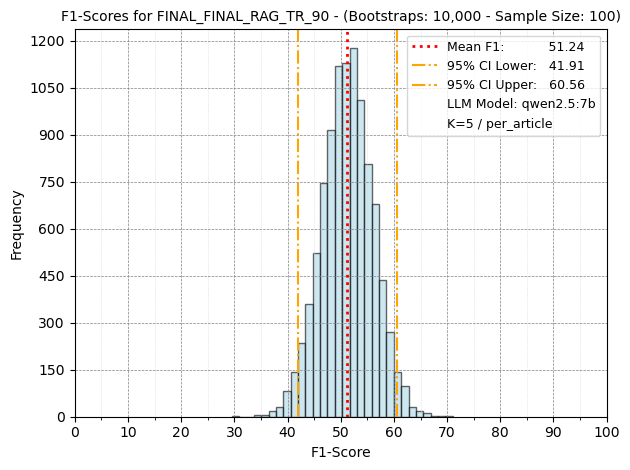

Will now persist the experiment configuration for FINAL_FINAL_RAG_TR_90...
Persisting the experiment config done...

================== Execution times (in seconds): ==================================

Total execution time in Minutes: 2.92


In [29]:
start_timestamp_str = get_timestamp_as_string()
results_folder_name = create_results_folder(start_timestamp_str)

exp = current_experiment

sample_ldict = sample_ldicts[exp["sample_ldicts_idx"]]
experiment_name = exp["name"]
query_prompt_idx = exp["query_prompt_idx"]
context_needed = exp["context_needed"]
hyde_context_needed = exp["hyde_context_needed"]
suppress_answers = exp["suppress_answers"]

print(f"experiment_name: {experiment_name}")
print(f"query_prompt_idx: {query_prompt_idx}")
print(f"context_needed: {context_needed}")
print(f"hyde_context_needed: {hyde_context_needed}")
print(f"suppress_answers: {suppress_answers}")
print(f"CHAT_MODEL_NAME: {CHAT_MODEL_NAME}")
print(f"VECTOR_STORE_TOP_K: {VECTOR_STORE_TOP_K}")
print(f"TEMPERATURE: {TEMPERATURE}")
print(f"JUDGES_SUPPRESS_THRESHOLD: {JUDGES_SUPPRESS_THRESHOLD}")

run_experiment(sample_ldict, start_timestamp_str, experiment_name, query_prompt_idx,
            context_needed, hyde_context_needed, suppress_answers)

print(f"\n================== Execution times (in seconds): ==================================\n")
df_execution_times = pd.DataFrame(execution_times_l, 
                                columns=['experiment_name', 'execution_time', 'sample_size', 'bootstrap_n'])

pd.options.display.float_format = "{:.2f}".format
df_execution_times.head(100)              

print(f"Total execution time in Minutes: {round(sum(df_execution_times['execution_time']) / 60, 2)}")

In [30]:
# Reset the display format for floats
pd.reset_option('display.float_format')

In [31]:
print(f"Total execution time in Minutes: {round(sum(df_execution_times['execution_time']) / 60, 2)}")

Total execution time in Minutes: 2.92
